In [1]:
from qiskit import pulse, circuit, transpile, assemble, schedule, IBMQ, QuantumCircuit, quantum_info as qi 
import qiskit
from qiskit.visualization import plot_gate_map, plot_error_map
from qiskit.visualization.pulse_v2 import draw
from qiskit.pulse import ShiftPhase, GaussianSquare, Drag, ControlChannel, MeasureChannel, DriveChannel, Play
import numpy as np
from qiskit.tools import job_monitor
from copy import deepcopy
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [118]:
account_provider = IBMQ.load_account()
provider_opts = {'hub': 'ibm-q-ncsu', 'group': 'nc-state', 'project':'noiseanderror'}

# target backend
backend_name = 'ibmq_jakarta'

provider = IBMQ.get_provider(**provider_opts)
backend = provider.get_backend(backend_name)

# backend information
config = backend.configuration()
defaults = backend.defaults()
properties = backend.properties()

# instruction schedule map
inst_map = defaults.instruction_schedule_map

ibmqfactory.load_account:WARNING:2021-11-08 11:59:07,082: Credentials are already in use. The existing account in the session will be replaced.


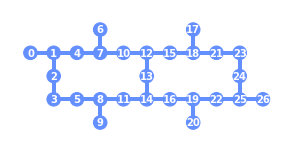

In [73]:
qubits = plot_gate_map(backend)
qubits

In [129]:
def extract_cr_params(cx_sched):
    cr_params = {}
    for time, inst in cx_sched.instructions:
        if isinstance(inst, Play):
            if isinstance(inst.pulse, GaussianSquare):
                if isinstance(inst.operands[1], ControlChannel):
                    cr_params["duration"] = inst.pulse.duration
                    cr_params["width"] = inst.pulse.width
                    cr_params["sigma"] = inst.pulse.sigma
                    cr_params["cr_amp"] = inst.pulse.amp
                    cr_params["channel"] = inst.channel
    return cr_params
                    

def build_cr_schedule(backend, qc, qt, cr_params, cr_name):
    
    with pulse.build(backend=backend, default_alignment="left", name="cr_schedule") as cross_resonance:
        pulse.play(GaussianSquare(
            duration=cr_params["duration"],
            amp=cr_params["cr_amp"],
            width=cr_params["width"],
            sigma=cr_params["sigma"],
            name=cr_name
        ),
        pulse.control_channels(qc, qt)[0],
    )
        if not np.isclose(cr_params["cancel_amp"], 0.0):
            pulse.play(GaussianSquare(
                duration=cr_params["duration"],
                amp=cr_params["cancel_amp"],
                width=cr_params["width"],
                sigma=cr_params["sigma"],
        ),
        pulse.drive_channel(qt),
    )
        else:
            pulse.delay(cr_params["duration"], pulse.drive_channel(qt))
        pulse.delay(cr_params["duration"], pulse.drive_channel(qc))
        
    return cross_resonance

def build_cr_circuit(gate):
    
    cr_circuit = QuantumCircuit(2)
    cr_circuit.append(gate, [0, 1])
#     cr_circuit.x(0)
#     cr_circuit.append(gate, [0, 1])
#     cr_circuit.x(0)
    
    return cr_circuit

def build_amp_experiment_circuits(backend, qc, qt, amps, cr_params, rotary=False):
    
    circ_list = []
    
    inst_map_list = []
    for amplitude in amps:
        
        new_inst_map = deepcopy(inst_map)
    

        cr_p_gate = circuit.Gate(
            "cr_p_gate",
            num_qubits=2,
            params=[amplitude],
        )
        
        
        cr_m_gate = circuit.Gate(
            "cr_m_gate",
            num_qubits=2,
            params=[-amplitude],
        )
        
        exp_circ = QuantumCircuit(2)

        ## add control state prep when needed

        exp_circ.compose(other=build_cr_circuit(cr_p_gate), qubits=[0, 1], inplace=True)
        exp_circ.x(0)
        exp_circ.compose(other=build_cr_circuit(cr_m_gate), qubits=[0, 1], inplace=True)
        exp_circ.x(0)
        
        exp_circ.metadata={
            "qubits": (qc, qt)
        }

        if rotary is True:
            cr_params['cancel_amp'] = amplitude
            
        cr_params["phi"] = 0
        cr_params['cr_amp'] = amplitude * np.exp(-1j*cr_params["phi"])
#         print(cr_params["cr_amp"], cr_params['phi'])
        exp_circ.add_calibration(gate=cr_p_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_p"))
        
        cr_params['phi'] = cr_params['phi'] + np.pi
        cr_params['cr_amp'] = amplitude * np.exp(-1j*cr_params["phi"])
#         print(cr_params["cr_amp"], cr_params['phi'])
        exp_circ.add_calibration(gate=cr_m_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_m"))
        exp_circ.measure_active()
        
#         new_inst_map.add('cr_gate', qubits=[qc, qt], schedule=build_cr_schedule(backend, qc, qt, cr_params))
        
        circ_list.append(exp_circ)
        inst_map_list.append(new_inst_map)
    return circ_list, inst_map_list

def expectation_val(count_dict, mem_ind):

    expv = 0
    for key, val in count_dict.items():
        if key[::-1][mem_ind] == '1':
#             print(key, val)
            expv -= val
        else:
            expv += val
#     print(expv)
    return expv / sum(count_dict.values())

In [130]:
q1, q2 = 0, 1
mem_ind = 0 if q1 > q2 else 1

# IBM's cross resonance gate
This is what IBM's cross-resonance gate looks like - extracted from the CX pulse schedule, and with the rotary tones not shown.

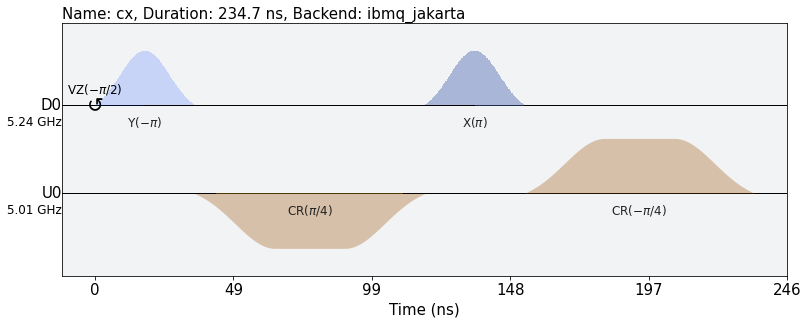

In [131]:
cx_sched = inst_map.get('cx', qubits=[q1, q2])
draw(cx_sched, backend=backend, disable_channels=[DriveChannel(q2)])

In [132]:
for time, inst in cx_sched.instructions:
    print(inst)

ShiftPhase(1.5707963267948966, DriveChannel(0))
ShiftPhase(1.5707963267948966, ControlChannel(1))
Play(Drag(duration=160, amp=(-3.643358643904867e-17-0.19833520687714562j), sigma=40, beta=-0.9796314280767204, name='Ym_d0'), DriveChannel(0), name='Ym_d0')
Play(Drag(duration=160, amp=(0.09596880093886541+0.002203220687696287j), sigma=40, beta=-0.9715686956228766, name='X90p_d1'), DriveChannel(1), name='X90p_d1')
Play(GaussianSquare(duration=368, amp=(0.11222765252972781+0.0024034159982227357j), sigma=64, width=112, name='CR90p_d1_u0'), DriveChannel(1), name='CR90p_d1_u0')
Play(GaussianSquare(duration=368, amp=(-0.00712837045458216-0.7573266706453817j), sigma=64, width=112, name='CR90p_u0'), ControlChannel(0), name='CR90p_u0')
Play(Drag(duration=160, amp=(0.19833520687714562+0j), sigma=40, beta=-0.9796314280767204, name='Xp_d0'), DriveChannel(0), name='Xp_d0')
Play(GaussianSquare(duration=368, amp=(-0.11222765252972781-0.002403415998222722j), sigma=64, width=112, name='CR90m_d1_u0'), Driv

In [133]:
cr_params = extract_cr_params(cx_sched)
cr_params["cancel_amp"] = 0.0
cr_params["phi"] = 0
# print(cr_params)

max_cr_amplitude = 1.0
cr_amps = np.linspace(-max_cr_amplitude, max_cr_amplitude, 70)
print(cr_amps)

[-1.         -0.97101449 -0.94202899 -0.91304348 -0.88405797 -0.85507246
 -0.82608696 -0.79710145 -0.76811594 -0.73913043 -0.71014493 -0.68115942
 -0.65217391 -0.62318841 -0.5942029  -0.56521739 -0.53623188 -0.50724638
 -0.47826087 -0.44927536 -0.42028986 -0.39130435 -0.36231884 -0.33333333
 -0.30434783 -0.27536232 -0.24637681 -0.2173913  -0.1884058  -0.15942029
 -0.13043478 -0.10144928 -0.07246377 -0.04347826 -0.01449275  0.01449275
  0.04347826  0.07246377  0.10144928  0.13043478  0.15942029  0.1884058
  0.2173913   0.24637681  0.27536232  0.30434783  0.33333333  0.36231884
  0.39130435  0.42028986  0.44927536  0.47826087  0.50724638  0.53623188
  0.56521739  0.5942029   0.62318841  0.65217391  0.68115942  0.71014493
  0.73913043  0.76811594  0.79710145  0.82608696  0.85507246  0.88405797
  0.91304348  0.94202899  0.97101449  1.        ]


In [134]:
exp_circuits, exp_inst_maps = build_amp_experiment_circuits(backend, q1, q2, cr_amps, cr_params)
# print(len(exp_circuits))
exp_circuits[19].draw()

┌──────────────────────┐┌───┐┌─────────────────────┐┌───┐ ░ ┌─┐   
      q_0: ┤0                     ├┤ X ├┤0                    ├┤ X ├─░─┤M├───
           │  cr_p_gate(-0.44928) │└───┘│  cr_m_gate(0.44928) │└───┘ ░ └╥┘┌─┐
      q_1: ┤1                     ├─────┤1                    ├──────░──╫─┤M├
           └──────────────────────┘     └─────────────────────┘      ░  ║ └╥┘
measure: 2/═════════════════════════════════════════════════════════════╩══╩═
                                                                        0  1

In [135]:
tc = transpile(exp_circuits, backend, initial_layout=[q1, q2])
sched = schedule(tc, backend)
for time, inst in sched[19].instructions:
    print(inst)

Delay(368, DriveChannel(0))
Delay(368, DriveChannel(1))
Play(GaussianSquare(duration=368, amp=(-0.4492753623188406+0j), sigma=64, width=112, name='cr_p'), ControlChannel(0), name='cr_p')
Play(Drag(duration=160, amp=(0.19833520687714562+0j), sigma=40, beta=-0.9796314280767204, name='Xp_d0'), DriveChannel(0), name='Xp_d0')
Delay(368, DriveChannel(0))
Delay(368, DriveChannel(1))
Play(GaussianSquare(duration=368, amp=(0.4492753623188406+5.502036343995355e-17j), sigma=64, width=112, name='cr_m'), ControlChannel(0), name='cr_m')
Play(Drag(duration=160, amp=(0.19833520687714562+0j), sigma=40, beta=-0.9796314280767204, name='Xp_d0'), DriveChannel(0), name='Xp_d0')
Acquire(22400, AcquireChannel(0), MemorySlot(0))
Acquire(22400, AcquireChannel(1), MemorySlot(1))
Play(GaussianSquare(duration=22400, amp=(-0.19500251978593602-0.01393797966477296j), sigma=64, width=22144, name='M_m0'), MeasureChannel(0), name='M_m0')
Play(GaussianSquare(duration=22400, amp=(-0.12869780599362984-0.14716359853043148j)

In [136]:
tc[4].draw()

┌──────────────────────┐┌───┐┌─────────────────────┐┌───┐ ░ ┌─┐»
      q_0 -> 0 ┤0                     ├┤ X ├┤0                    ├┤ X ├─░─┤M├»
               │  cr_p_gate(-0.88406) │└───┘│  cr_m_gate(0.88406) │└───┘ ░ └╥┘»
      q_1 -> 1 ┤1                     ├─────┤1                    ├──────░──╫─»
               └──────────────────────┘     └─────────────────────┘      ░  ║ »
ancilla_0 -> 2 ─────────────────────────────────────────────────────────────╫─»
                                                                            ║ »
ancilla_1 -> 3 ─────────────────────────────────────────────────────────────╫─»
                                                                            ║ »
ancilla_2 -> 4 ─────────────────────────────────────────────────────────────╫─»
                                                                            ║ »
ancilla_3 -> 5 ─────────────────────────────────────────────────────────────╫─»
                                                                            ║ »
ancilla_4 -> 6 ─────────────────────────────────────────────────────────────╫─»
                                                                            ║ »
    measure: 2/═════════════════════════════════════════════════════════════╩═»
                                                                            0 »
«                  
«      q_0 -> 0 ───
«               ┌─┐
«      q_1 -> 1 ┤M├
«               └╥┘
«ancilla_0 -> 2 ─╫─
«                ║ 
«ancilla_1 -> 3 ─╫─
«                ║ 
«ancilla_2 -> 4 ─╫─
«                ║ 
«ancilla_3 -> 5 ─╫─
«                ║ 
«ancilla_4 -> 6 ─╫─
«                ║ 
«    measure: 2/═╩═
«                1

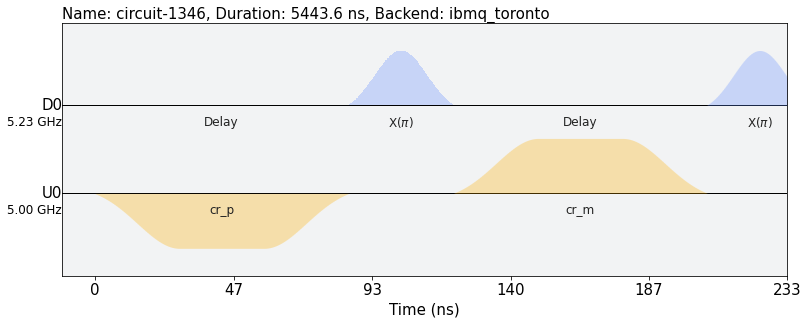

In [96]:
draw(sched[4], backend=backend, time_range=[0, 1000], disable_channels=[MeasureChannel(q1), MeasureChannel(q2)])

In [97]:
i = 1
identifier = F"({q1},{q2})"

In [98]:
job = backend.run(tc, job_name=F"cr_amp_exp_{identifier}", shots=2048)
job_id = job.job_id()
print(job.job_id())

61895180145277452e117c10


In [119]:
# 11/8/2021 - amplitude experiments
# ibm_lagos job (9:45~ am) - 6189380f1452777724117b88
# ibmq_jakarta job (10:00~ am) - 61893b88902694642fd98881
# ibmq_jakarta (10:30~ am) - 6189411bc45f2664c31517c5
# ibmq_jakarta (10:51~ am) - 61894761ad7fa029bcd1440f * best results so far (sweeping from (-1.0, 1.0, 70))
# ibmq_jakarta (11:23~ am) - 61894f14ad7fa0ed2ad14439 
# ibmq_montreal (11:18~ am) - 61894de8c45f2661c61517fb
# ibmq_toronto (11:27~ am) - 61894fdab3f4906ac760bf9e
# ibmq_toronto (11:33~ am) - 61895180145277452e117c10
job_id = "61894761ad7fa029bcd1440f"
results = backend.retrieve_job(job_id).result()
i+=1

In [120]:
count_dict = results.get_counts()
print(count_dict)

[{'00': 780, '01': 19, '10': 1229, '11': 20}, {'00': 789, '01': 11, '10': 1228, '11': 20}, {'00': 793, '01': 17, '10': 1225, '11': 13}, {'00': 842, '01': 22, '10': 1172, '11': 12}, {'00': 869, '01': 22, '10': 1140, '11': 17}, {'00': 921, '01': 27, '10': 1091, '11': 9}, {'00': 905, '01': 22, '10': 1104, '11': 17}, {'00': 1001, '01': 22, '10': 1019, '11': 6}, {'00': 1020, '01': 31, '10': 982, '11': 15}, {'00': 1058, '01': 17, '10': 958, '11': 15}, {'00': 1058, '01': 9, '10': 968, '11': 13}, {'00': 1121, '01': 13, '10': 901, '11': 13}, {'00': 1174, '01': 24, '10': 836, '11': 14}, {'00': 1210, '01': 24, '10': 811, '11': 3}, {'00': 1228, '01': 25, '10': 788, '11': 7}, {'00': 1271, '01': 24, '10': 743, '11': 10}, {'00': 1311, '01': 25, '10': 703, '11': 9}, {'00': 1392, '01': 31, '10': 615, '11': 10}, {'00': 1437, '01': 23, '10': 578, '11': 10}, {'00': 1465, '01': 30, '10': 543, '11': 10}, {'00': 1489, '01': 33, '10': 518, '11': 8}, {'00': 1584, '01': 25, '10': 433, '11': 6}, {'00': 1599, '01

In [121]:
def cr_fit_3rd_order_perturbation(x, c1, c2):
    fx = c1*x - c2*x**3
    return np.cos(2 * np.pi * fx)

def rough_amp_objective(x, params, opt_phase):
    fx = params[0] * x - params[1] * x**3
    return np.abs(opt_phase / 2 / np.pi - fx)

In [125]:
exp_z = np.zeros_like(cr_amps)
for cind in range(len(cr_amps)):
    exp_z[cind] = expectation_val(count_dict[cind], mem_ind=mem_ind)
print(exp_z)
valid_inds = np.where(np.abs(cr_amps) < 1.0)[0]
params, _ = opt.curve_fit(cr_fit_3rd_order_perturbation, xdata=cr_amps[valid_inds], ydata=exp_z[valid_inds])
cr_pi2_amp = opt.minimize(rough_amp_objective, x0=0, bounds=[(0, 1)], args=(params, 0.5 * np.pi)).x[0]

[-2.19726562e-01 -2.18750000e-01 -2.08984375e-01 -1.56250000e-01
 -1.29882812e-01 -7.42187500e-02 -9.47265625e-02 -9.76562500e-04
  2.63671875e-02  4.98046875e-02  4.19921875e-02  1.07421875e-01
  1.69921875e-01  2.05078125e-01  2.23632812e-01  2.64648438e-01
  3.04687500e-01  3.89648438e-01  4.25781250e-01  4.59960938e-01
  4.86328125e-01  5.71289062e-01  5.92773438e-01  6.50390625e-01
  6.96289062e-01  7.20703125e-01  7.64648438e-01  8.23242188e-01
  8.67187500e-01  8.73046875e-01  9.18945312e-01  9.38476562e-01
  9.58007812e-01  9.61914062e-01  9.77539062e-01  9.81445312e-01
  9.81445312e-01  9.73632812e-01  9.51171875e-01  9.35546875e-01
  9.09179688e-01  8.70117188e-01  8.59375000e-01  8.16406250e-01
  7.79296875e-01  7.19726562e-01  7.05078125e-01  6.62109375e-01
  5.95703125e-01  5.64453125e-01  4.98046875e-01  4.65820312e-01
  4.48242188e-01  3.96484375e-01  3.27148438e-01  3.22265625e-01
  2.41210938e-01  2.39257812e-01  1.59179688e-01  1.32812500e-01
  1.40625000e-01  5.76171

In [126]:
print(cr_pi2_amp)

0.7790333093589549


(-1.0, 1.0)

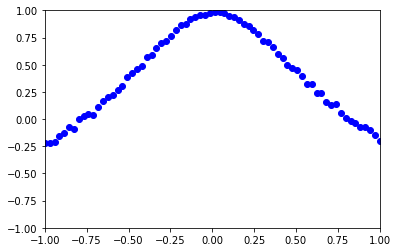

In [128]:
plt.plot(cr_amps, exp_z, 'o', color='b')
plt.xlim(-max_cr_amplitude, max_cr_amplitude)
plt.ylim(-1, 1)


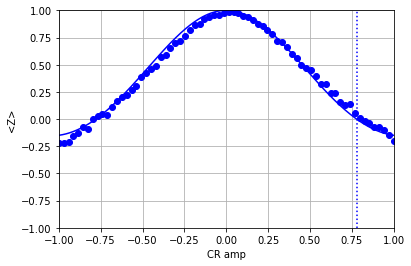

In [127]:
x_interp = np.linspace(cr_amps[0], cr_amps[-1], 1000)
plt.plot(cr_amps, exp_z, 'o', color='b')
plt.plot(x_interp, cr_fit_3rd_order_perturbation(x_interp, *params), color='b')
plt.plot([cr_pi2_amp, cr_pi2_amp], [-1, 1], 'b:')
plt.xlim(-max_cr_amplitude, max_cr_amplitude)
plt.ylim(-1, 1)
plt.xlabel('CR amp')
plt.ylabel('<Z>')
plt.grid()